## Импорт библиотек

In [ ]:
import zipfile # Библиотека для работы с zip архивами
import os      # Библиотека для работы с фаловой системой
from google.colab import drive # Модуль для работы с Google Disk

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms
# import torchvision.datasets as datasets

from tqdm import tqdm

## Загрузка данных

In [ ]:
drive.mount('/content/drive')

# Прописываем путь к файлу с архивом
zip_file = "drive/My Drive/Deep Learning projects/DCGAN/celeb_dataset.zip"

# Распаковываем архив
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()


# Просмотр результата разархивации
print(os.listdir())

Mounted at /content/drive
['.config', 'celeb_dataset', 'drive', 'sample_data']


In [ ]:
celeb_img_path = './celeb_dataset/'
# celeb = './celeb_dataset/'

## Архитектура модели

Реализуем модель из статьи (https://arxiv.org/pdf/1511.06434.pdf). Эта модель будет генерировать лица людей из датасета ***CelebA*** (https://www.kaggle.com/datasets/504743cb487a5aed565ce14238c6343b7d650ffd28c071f03f2fd9b25819e6c9)

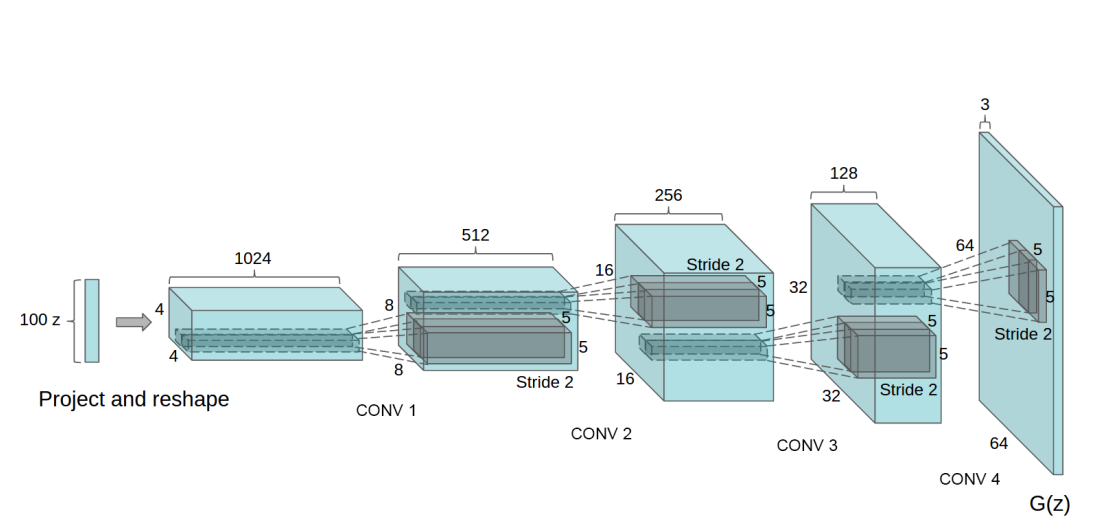

Чуть выше представлена модель генератора. Дискриминатор будет иметь такую же структуру, только зеркально симметрично

### Дискриминатор

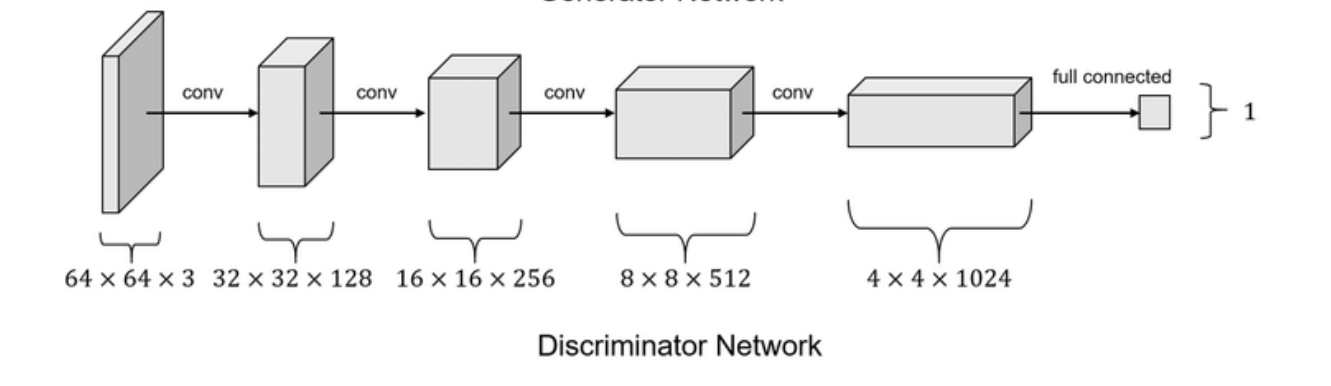

In [ ]:
def CNA_block_d(in_channels, out_channels, kernel_size, stride, padding):
    x = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2)
    )
    return x

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, img_channels):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(img_channels, 128, kernel_size=4, stride=2, padding=1),
            CNA_block_d(128, 256, 4, 2, 1),
            CNA_block_d(256, 512, 4, 2, 1),
            CNA_block_d(512, 1024, 4, 2, 1),
            nn.Conv2d(1024, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.disc(x)

### Генератор

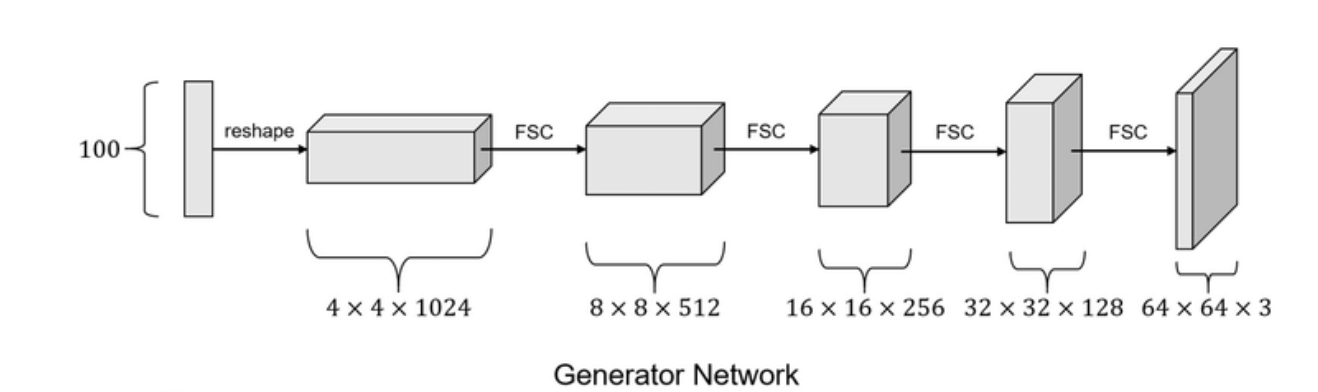

In [ ]:
def CNA_block_g(in_channels, out_channels, kernel_size, stride, padding):
    x = nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2)
    )
    return x

In [ ]:
class Generator(nn.Module):
    def __init__(self, noise_channels, img_channels):
        super().__init__()
        self.gen = nn.Sequential(
            CNA_block_g(noise_channels, 1024, 4, 1, 0),
            CNA_block_g(1024, 512, 4, 2, 1),
            CNA_block_g(512, 256, 4, 2, 1),
            CNA_block_g(256, 128, 4, 2, 1),
            nn.ConvTranspose2d(128, img_channels, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.gen(x)

In [ ]:
x = torch.randn(1, 3, 64, 64)
disc = Discriminator(3)
# disc(x).shape
z = torch.randn(1, 100, 1, 1)
gen = Generator(100, 3)

if gen(z).shape == x.shape:
    print('Succes!')
    print(f'Output shape:{gen(z).shape}')

Succes!
Output shape:torch.Size([1, 3, 64, 64])


### Инициализация весов

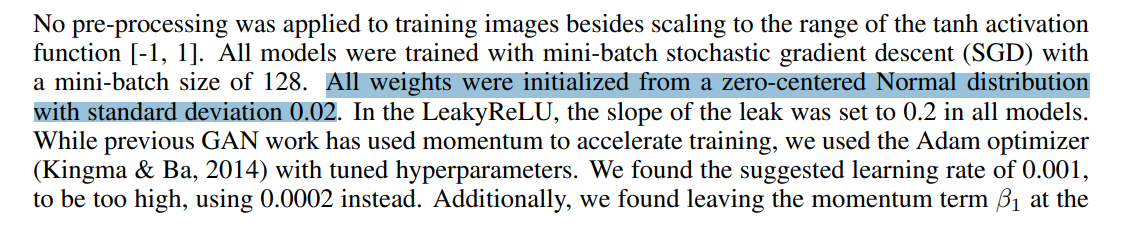

Веса модели задаются из нормального распределения с мат. ожиданием **0** и дисперсией **0.02**

In [ ]:
def init_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.ConvTranspose2d, nn.Conv2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0, 0.02)

## Гиперпараметры

In [55]:
device = "cuda" if torch.cuda.is_available() else "cpu"
noise_dim = 100
img_size = 64
epochs = 5
batch_size = 128
# step = 0

## Обучение

In [ ]:
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
dataset = torchvision.datasets.ImageFolder(root=celeb_img_path, transform=transform)
loader = DataLoader(dataset, batch_size, shuffle=True)

disc = Discriminator(3).to(device)
gen = Generator(noise_dim, 3).to(device)

init_weights(disc)
init_weights(gen)

opt_disc = optim.Adam(disc.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_gen = optim.Adam(gen.parameters(), lr=2e-4, betas=(0.5, 0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(32, noise_dim, 1, 1).to(device) # этот шум кидаем в обучаемую модель, чтобы визуализировать обучение модели
fake_imd_list = []

loss_G_list = []
loss_D_list = []

In [ ]:
for epoch in tqdm(range(epochs)):
    for batch_idx, (real, label) in enumerate(loader):
        real = real.to(device)

        # Обучение дискриминатора
        noise = torch.randn((batch_size, noise_dim, 1, 1)).to(device)
        fake = gen(noise)

        disc_real = disc(real).reshape(-1)
        loss_real = criterion(disc_real, torch.ones_like(disc_real))

        disc_fake = disc(fake.detach()).reshape(-1)
        loss_fake = criterion(disc_fake, torch.zeros_like(disc_fake))

        loss_D = (loss_real + loss_fake)
        opt_disc.zero_grad()
        loss_D.backward()
        opt_disc.step()

        # Обучение генератора
        preds = disc(fake).reshape(-1)
        loss_G = criterion(preds, torch.ones_like(preds))
        opt_gen.zero_grad()
        loss_G.backward()
        opt_gen.step()

        if batch_idx == 0:
            print(f"Epoch:{epoch} **** Loss_D {loss_D:.2f} **** Loss_G {loss_G:.2f}")
            loss_G_list.append(loss_G.cpu().detach().numpy())
            loss_D_list.append(loss_D.cpu().detach().numpy())

            if (epoch + 1) % 2 == 0:
                with torch.no_grad():
                    fake = gen(fixed_noise)

                    fake_img_grid = torchvision.utils.make_grid(fake, normalize=True)
                    fake_imd_list.append(fake_img_grid)




  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:0 **** Loss_D 0.00 **** Loss_G 14.36


 20%|██        | 1/5 [14:39<58:38, 879.65s/it]

Epoch:1 **** Loss_D 0.00 **** Loss_G 15.41


 40%|████      | 2/5 [29:15<43:52, 877.53s/it]

Epoch:2 **** Loss_D 0.00 **** Loss_G 16.18


## Сохранение на диск

In [ ]:
num_epochs = 25
disc_save_name, gen_save_name = f'DCGAN_disc{str(num_epochs)}.pt', f'DCGAN_gen{str(num_epochs)}.pt'
PATH_disc = f"/content/drive/My Drive/My_save_models/DCGAN/{disc_save_name}"
PATH_gen = f"/content/drive/My Drive/My_save_models/DCGAN/{gen_save_name}"

torch.save(disc.state_dict(), PATH_disc)
torch.save(gen.state_dict(), PATH_gen)


## Загрузка из диска

In [51]:
disc_save_name, gen_save_name = 'DCGAN_disc.pt', 'DCGAN_gen.pt'

PATH_disc = f"/content/drive/My Drive/My_save_models/DCGAN/{disc_save_name}"
PATH_gen = f"/content/drive/My Drive/My_save_models/DCGAN/{gen_save_name}"

disc.load_state_dict(torch.load(PATH_disc))
gen.load_state_dict(torch.load(PATH_gen))

<All keys matched successfully>

## Отображение результатов

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
fig, ax = plt.subplots(nrows=len(fake_imd_list), figsize=(40, 40))
ax = ax.flatten()

for i, fake in enumerate(fake_imd_list):
  fake_img = transforms.ToPILImage()(fake)
  ax[i].imshow(fake_img)
  ax[i].set_title(f'{i*2} epoch')
  ax[i].get_xaxis().set_visible(False)
  ax[i].get_yaxis().set_visible(False)


Output hidden; open in https://colab.research.google.com to view.

In [42]:

# loss_G_list = [loss.cpu().detach().numpy() for loss in loss_G_list]
# loss_D_list = [loss.cpu().detach().numpy() for loss in loss_D_list]


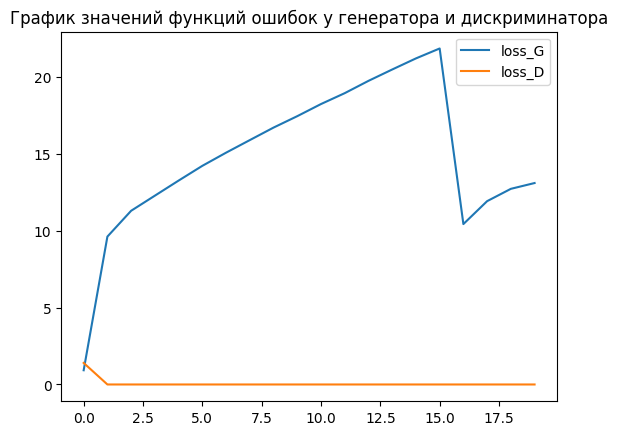

In [50]:
plt.figure()
x = [i for i in range(25)]

plt.plot(x, loss_G_list[:25], label='loss_G')
plt.plot(x, loss_D_list[:25], label='loss_D')
plt.legend(('loss_G', 'loss_D'))
plt.title('График значений функций ошибок у генератора и дискриминатора на первых 25 эпохах')
plt.show()